In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
import math
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
#from tensorflow.keras.datasets import cifar10 
from keras.datasets import fashion_mnist 
#from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

(60000, 28, 28) (10000, 28, 28)


In [4]:
local = 21 # 10개 : 1~10 => 11은 포함 안됨
batch_size, epochs = 32, 5
global_epoch = 0
num_layers = 8

num_clusters = 2

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

x_train = x_train.reshape((num_train, 28, 28, 1))
x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (60000, 28, 28)
Step 2 x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
#랜덤 비복원추출, 동등하게 10% 씩 =  로컬 데이터 추출 ------------------------------------------------------------------------------

global_epoch = 0


print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  

x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
    tmp, tmp2 = [], []
    tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.

print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
check=>: should be 0 ==  60000
0  번째 global_epoch 데이터 랜덤 준비완료!!


In [7]:
#준비된 데이터 (IID / NON-IID) np.array로


global_epoch = 0
acc, loss = 0, 0
cluster_acc, cluster_loss, Cluster_ACC, Cluster_LOSS = [], [], [], [] 
num_layers_list = [0,2,4,6,7]
label_list = []
VAR_final_list_w, VAR_final_list_b = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    cluster_acc.append(acc)  #acc 넣기
    cluster_loss.append(loss)  #loss 넣기


print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            
# 클러스터에 넣을 변수 선언

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['var_list_layer{}_w'.format(layer_index)] = []
    globals()['var_list_layer{}_b'.format(layer_index)] = []
  
    for i in range(1, local):
        globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][0]))
        globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][1]))
      
        TMP_w = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][0]).reshape(-1))
        TMP_b = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][1]).reshape(-1))
        
        TMP_w.extend(TMP_b) ##append 말고 더해야함..

        TMP_w = np.array(TMP_w)
        TMP_w = list(TMP_w.reshape(-1))
        globals()['layer{}_W_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도
  

    #----------------------------------------------------클러스터링 실시 -------------------------------------------------------------
    transformed = globals()['layer{}_W_tmp'.format(layer_index)]

    kmeans_model_w = KMeans(n_clusters = num_clusters)   # 0, 1은 silhouette 에 안먹힘  

    globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 

    globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = num_clusters  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
    
    label_list.append(globals()['w_layer{}_label'.format(layer_index)])                 

    # ==========> 클러스터 갯수 정해짐


    #----------------------------------------------- 스케일링  ---------------------------------------------------------------------
    for num_c_w in range(num_clusters): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0  #각각 cluster, Act+cluster 용도  
        
        globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
    
        for i in range(1, local):
            if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링
                
                globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

        globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균


#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------

transformed = 0
Cluster_ACC.append(cluster_acc)
Cluster_LOSS.append(cluster_loss)



 0 번째 global epoch에서 로컬 클라이언트 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.5224 - accuracy: 0.8180
16/16 - 0s - loss: 0.5348 - accuracy: 0.8000
16/16 - 0s - loss: 0.5229 - accuracy: 0.8060
16/16 - 0s - loss: 0.5948 - accuracy: 0.7860
16/16 - 0s - loss: 0.5231 - accuracy: 0.8020
16/16 - 0s - loss: 0.5983 - accuracy: 0.7720
16/16 - 0s - loss: 0.5793 - accuracy: 0.7780
16/16 - 0s - loss: 0.6786 - accuracy: 0.7660
16/16 - 0s - loss: 0.5162 - accuracy: 0.8160
16/16 - 0s - loss: 0.5482 - accuracy: 0.7940
16/16 - 0s - loss: 0.5902 - accuracy: 0.7740
16/16 - 0s - loss: 0.5024 - accuracy: 0.8120
16/16 - 0s - loss: 0.5400 - accuracy: 0.8100
16/16 - 0s - loss: 0.5635 - accuracy: 0.7920
16/16 - 0s - loss: 0.5958 - accuracy: 0.7800
16/16 - 0s - loss: 0.5419 - accuracy: 0.8020
16/16 - 0s - loss: 0.5832 - accuracy: 0.7680
16/16 - 0s - loss: 0.5849 - accuracy: 0.7980
16/16 - 0s - loss: 0.5660 - accuracy: 0.8100
16/16 - 0s - loss: 0.4978 - accuracy: 0.8320
0 번째 global epoch 로컬 클라이언트 학습완료!,  Total Training t

<ipython-input-7-62086c157ead>:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링
<ipython-input-7-62086c157ead>:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(glob

In [8]:
G_epoch = 42

for global_epoch in range(1, G_epoch):

    for i in range(1, local):
        if global_epoch == 1:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #모델 넣어줌 (우리는 구조만 필요한 것)
        else:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['G{}_c_L{}_model'.format(global_epoch-1, i)]   #모델 넣어줌 (우리는 구조만 필요한 것)

        for layer_index in num_layers_list: 
            num_c = globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch-1, layer_index)]   
    
            for ccc in range(num_c):
                if globals()['w_layer{}_label'.format(layer_index)][i-1] == ccc:    #현재 로컬 레이어의 군집 결과 == ccc
                    globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].set_weights(globals()['G{}_c{}_w_layer{}'.format(global_epoch-1, ccc, layer_index) ])  # 클러스터용 로컬 모델 선언
                    
                  
    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

    for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []  
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  

    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
        tmp, tmp2 = [], []
        tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")

    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    

    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------


    #======================================================================== Cluster  ========================================================================  같이 했음. 왜냐면 cluster 하고 나서 activation 을 씌우는 거라 cluster까지는 같음

    cluster_acc, cluster_loss, cluster_act_acc, cluster_act_loss, now = [], [], [], [], time.time()
    
    for i in range(1, local):
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])  #Cluster => 알맞는 클러스터에 넣기
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        loss, acc = globals()['G{}_c_L{}_model'.format(global_epoch, i)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        cluster_acc.append(acc)  #acc 넣기
        cluster_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in num_layers_list:
            
            globals()['L{}_layer{}_w_c'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 
            globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 

    #------------------------------------------------ 클러스터링만 한 값들 Clustering --------------------------------------------------------
    for layer_index in num_layers_list:
        globals()['layer{}_W_c_tmp'.format(layer_index)] = []

        for i in range(1, local):
            TMP_w = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][0]).reshape(-1))
            TMP_b = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][1]).reshape(-1))
            
            TMP_w.extend(TMP_b) ##append 말고 더해야함..

            TMP_w = np.array(TMP_w)
            TMP_w = list(TMP_w.reshape(-1))
            globals()['layer{}_W_c_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도

        #---------------------------------------------------- 실루엣 기반 클러스터링 실시 -------------------------------------------------------------
        transformed = globals()['layer{}_W_c_tmp'.format(layer_index)]

        kmeans_model_w = KMeans(n_clusters = num_clusters)   # 0, 1은 silhouette 에 안먹힘  

        globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 
        label_list.append(globals()['w_layer{}_label'.format(layer_index)])

        globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = num_clusters  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
        

        #----------------------------------------------- 스케일링 및 업데이트 ---------------------------------------------------------------------
        for num_c_w in range(num_clusters): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0 
            
            globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
        
            for i in range(1, local):

                if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                    globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                    globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
                  
                    globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

            globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균


    Cluster_ACC.append(cluster_acc)
    Cluster_LOSS.append(cluster_loss)

    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")

1  번째 global_epoch 데이터 랜덤하게 준비!!
1  번째 global_epoch 데이터 랜덤 준비완료!!


1  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.7658 - accuracy: 0.7160
16/16 - 0s - loss: 0.8357 - accuracy: 0.6700
16/16 - 0s - loss: 0.9507 - accuracy: 0.6380
16/16 - 0s - loss: 0.6714 - accuracy: 0.7480
16/16 - 0s - loss: 0.8335 - accuracy: 0.6920
16/16 - 0s - loss: 0.6275 - accuracy: 0.7660
16/16 - 0s - loss: 0.7537 - accuracy: 0.7500
16/16 - 0s - loss: 0.8055 - accuracy: 0.6960
16/16 - 0s - loss: 0.7149 - accuracy: 0.7100
16/16 - 0s - loss: 0.8123 - accuracy: 0.7100
16/16 - 0s - loss: 0.8235 - accuracy: 0.6920
16/16 - 0s - loss: 0.8207 - accuracy: 0.6980
16/16 - 0s - loss: 0.7368 - accuracy: 0.7220
16/16 - 0s - loss: 0.6339 - accuracy: 0.7680
16/16 - 0s - loss: 0.7986 - accuracy: 0.6820
16/16 - 0s - loss: 0.9938 - accuracy: 0.6200
16/16 - 0s - loss: 0.7470 - accuracy: 0.7080
16/16 - 0s - loss: 0.7772 - accuracy: 0.6820
16/16 - 0s - loss: 0.7935 - accuracy: 0.7020
16/16 - 0s - loss: 0.8043 - 

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


2  번째 global_epoch 데이터 랜덤하게 준비!!
2  번째 global_epoch 데이터 랜덤 준비완료!!


2  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.7716 - accuracy: 0.7060
16/16 - 0s - loss: 0.6459 - accuracy: 0.7540
16/16 - 0s - loss: 0.6736 - accuracy: 0.7480
16/16 - 0s - loss: 0.6959 - accuracy: 0.7340
16/16 - 0s - loss: 0.7547 - accuracy: 0.7200
16/16 - 0s - loss: 0.7831 - accuracy: 0.7220
16/16 - 0s - loss: 0.7150 - accuracy: 0.7580
16/16 - 0s - loss: 0.6275 - accuracy: 0.7440
16/16 - 0s - loss: 0.6837 - accuracy: 0.7560
16/16 - 0s - loss: 0.7364 - accuracy: 0.7300
16/16 - 0s - loss: 0.6774 - accuracy: 0.7460
16/16 - 0s - loss: 0.7264 - accuracy: 0.7540
16/16 - 0s - loss: 0.6968 - accuracy: 0.7320
16/16 - 0s - loss: 0.7697 - accuracy: 0.7420
16/16 - 0s - loss: 0.7227 - accuracy: 0.7120
16/16 - 0s - loss: 0.5690 - accuracy: 0.7940
16/16 - 0s - loss

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


3  번째 global_epoch 데이터 랜덤하게 준비!!
3  번째 global_epoch 데이터 랜덤 준비완료!!


3  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.5496 - accuracy: 0.7840
16/16 - 0s - loss: 0.5913 - accuracy: 0.7840
16/16 - 0s - loss: 0.6648 - accuracy: 0.7360
16/16 - 0s - loss: 0.5875 - accuracy: 0.7780
16/16 - 0s - loss: 0.5832 - accuracy: 0.7820
16/16 - 0s - loss: 0.5591 - accuracy: 0.7920
16/16 - 0s - loss: 0.7571 - accuracy: 0.7120
16/16 - 0s - loss: 0.5731 - accuracy: 0.7880
16/16 - 0s - loss: 0.6477 - accuracy: 0.7380
16/16 - 0s - loss: 0.6218 - accuracy: 0.7720
16/16 - 0s - loss: 0.5630 - accuracy: 0.8000
16/16 - 0s - loss: 0.6247 - accuracy: 0.7740
16/16 - 0s - loss: 0.6301 - accuracy: 0.7700
16/16 - 0s - loss: 0.6735 - accuracy: 0.7420
16/16 - 0s - loss: 0.5401 - accuracy: 0.7960
16/16 - 0s - loss: 0.5386 - accuracy: 0.8120
16/16 - 0s - loss

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


4  번째 global_epoch 데이터 랜덤하게 준비!!
4  번째 global_epoch 데이터 랜덤 준비완료!!


4  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.6247 - accuracy: 0.7740
16/16 - 0s - loss: 0.6288 - accuracy: 0.7820
16/16 - 0s - loss: 0.6013 - accuracy: 0.7900
16/16 - 0s - loss: 0.5429 - accuracy: 0.7780
16/16 - 0s - loss: 0.5203 - accuracy: 0.8100
16/16 - 0s - loss: 0.5735 - accuracy: 0.8000
16/16 - 0s - loss: 0.4933 - accuracy: 0.8060
16/16 - 0s - loss: 0.5214 - accuracy: 0.8340
16/16 - 0s - loss: 0.5793 - accuracy: 0.7700
16/16 - 0s - loss: 0.6178 - accuracy: 0.7580
16/16 - 0s - loss: 0.5072 - accuracy: 0.8080
16/16 - 0s - loss: 0.5846 - accuracy: 0.7860
16/16 - 0s - loss: 0.5129 - accuracy: 0.8020
16/16 - 0s - loss: 0.5195 - accuracy: 0.8040
16/16 - 0s - loss: 0.5481 - accuracy: 0.7980
16/16 - 0s - loss: 0.5916 - accuracy: 0.7740
16/16 - 0s - loss

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


5  번째 global_epoch 데이터 랜덤하게 준비!!
5  번째 global_epoch 데이터 랜덤 준비완료!!


5  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.5559 - accuracy: 0.7900
16/16 - 0s - loss: 0.5721 - accuracy: 0.7980
16/16 - 0s - loss: 0.5433 - accuracy: 0.8060
16/16 - 0s - loss: 0.5389 - accuracy: 0.8100
16/16 - 0s - loss: 0.6118 - accuracy: 0.7480
16/16 - 0s - loss: 0.5823 - accuracy: 0.7760
16/16 - 0s - loss: 0.5714 - accuracy: 0.8200
16/16 - 0s - loss: 0.5425 - accuracy: 0.7940
16/16 - 0s - loss: 0.5946 - accuracy: 0.7800
16/16 - 0s - loss: 0.5061 - accuracy: 0.8320
16/16 - 0s - loss: 0.5015 - accuracy: 0.7920
16/16 - 0s - loss: 0.5423 - accuracy: 0.7980
16/16 - 0s - loss: 0.6043 - accuracy: 0.7700
16/16 - 0s - loss: 0.5043 - accuracy: 0.8080
16/16 - 0s - loss: 0.5571 - accuracy: 0.7900
16/16 - 0s - loss: 0.6483 - accuracy: 0.7760
16/16 - 0s - loss

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


6  번째 global_epoch 데이터 랜덤하게 준비!!
6  번째 global_epoch 데이터 랜덤 준비완료!!


6  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.5648 - accuracy: 0.8160
16/16 - 0s - loss: 0.5356 - accuracy: 0.8100
16/16 - 0s - loss: 0.5227 - accuracy: 0.8040
16/16 - 0s - loss: 0.5607 - accuracy: 0.7980
16/16 - 0s - loss: 0.5675 - accuracy: 0.8300
16/16 - 0s - loss: 0.6153 - accuracy: 0.7960
16/16 - 0s - loss: 0.4997 - accuracy: 0.8340
16/16 - 0s - loss: 0.5522 - accuracy: 0.8100
16/16 - 0s - loss: 0.4720 - accuracy: 0.8320
16/16 - 0s - loss: 0.5390 - accuracy: 0.8120
16/16 - 0s - loss: 0.5305 - accuracy: 0.8080
16/16 - 0s - loss: 0.6288 - accuracy: 0.7660
16/16 - 0s - loss: 0.4714 - accuracy: 0.8380
16/16 - 0s - loss: 0.4529 - accuracy: 0.8520
16/16 - 0s - loss: 0.5554 - accuracy: 0.8200
16/16 - 0s - loss: 0.4637 - accuracy: 0.8300
16/16 - 0s - loss

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


7  번째 global_epoch 데이터 랜덤하게 준비!!
7  번째 global_epoch 데이터 랜덤 준비완료!!


7  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.5060 - accuracy: 0.7960
16/16 - 0s - loss: 0.4802 - accuracy: 0.8340
16/16 - 0s - loss: 0.5446 - accuracy: 0.8220
16/16 - 0s - loss: 0.5027 - accuracy: 0.8160
16/16 - 0s - loss: 0.5060 - accuracy: 0.8340
16/16 - 0s - loss: 0.5972 - accuracy: 0.7840
16/16 - 0s - loss: 0.4953 - accuracy: 0.8100
16/16 - 0s - loss: 0.4982 - accuracy: 0.8400
16/16 - 0s - loss: 0.4778 - accuracy: 0.8200
16/16 - 0s - loss: 0.5220 - accuracy: 0.8160
16/16 - 0s - loss: 0.4318 - accuracy: 0.8340
16/16 - 0s - loss: 0.4980 - accuracy: 0.8120
16/16 - 0s - loss: 0.4828 - accuracy: 0.8220
16/16 - 0s - loss: 0.5459 - accuracy: 0.8300
16/16 - 0s - loss: 0.6773 - accuracy: 0.7740
16/16 - 0s - loss: 0.4178 - accuracy: 0.8660
16/16 - 0s - loss

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


8  번째 global_epoch 데이터 랜덤하게 준비!!
8  번째 global_epoch 데이터 랜덤 준비완료!!


8  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4603 - accuracy: 0.8380
16/16 - 0s - loss: 0.4947 - accuracy: 0.8220
16/16 - 0s - loss: 0.5085 - accuracy: 0.8180
16/16 - 0s - loss: 0.4687 - accuracy: 0.8320
16/16 - 0s - loss: 0.4970 - accuracy: 0.8200
16/16 - 0s - loss: 0.5903 - accuracy: 0.8320
16/16 - 0s - loss: 0.5010 - accuracy: 0.8240
16/16 - 0s - loss: 0.5862 - accuracy: 0.7800
16/16 - 0s - loss: 0.4955 - accuracy: 0.8420
16/16 - 0s - loss: 0.5330 - accuracy: 0.8180
16/16 - 0s - loss: 0.3935 - accuracy: 0.8440
16/16 - 0s - loss: 0.4013 - accuracy: 0.8640
16/16 - 0s - loss: 0.4217 - accuracy: 0.8340
16/16 - 0s - loss: 0.4722 - accuracy: 0.8500
16/16 - 0s - loss: 0.5671 - accuracy: 0.8080
16/16 - 0s - loss: 0.5371 - accuracy: 0.8260
16/16 - 0s - loss

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


9  번째 global_epoch 데이터 랜덤하게 준비!!
9  번째 global_epoch 데이터 랜덤 준비완료!!


9  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4628 - accuracy: 0.8320
16/16 - 0s - loss: 0.4742 - accuracy: 0.8360
16/16 - 0s - loss: 0.4672 - accuracy: 0.8300
16/16 - 0s - loss: 0.4138 - accuracy: 0.8420
16/16 - 0s - loss: 0.4976 - accuracy: 0.8340
16/16 - 0s - loss: 0.4756 - accuracy: 0.8360
16/16 - 0s - loss: 0.5085 - accuracy: 0.8280
16/16 - 0s - loss: 0.5151 - accuracy: 0.8140
16/16 - 0s - loss: 0.3563 - accuracy: 0.8660
16/16 - 0s - loss: 0.3775 - accuracy: 0.8580
16/16 - 0s - loss: 0.4619 - accuracy: 0.8360
16/16 - 0s - loss: 0.4531 - accuracy: 0.8560
16/16 - 0s - loss: 0.4276 - accuracy: 0.8380
16/16 - 0s - loss: 0.5459 - accuracy: 0.8240
16/16 - 0s - loss: 0.5360 - accuracy: 0.8100
16/16 - 0s - loss: 0.3737 - accuracy: 0.8620
16/16 - 0s - loss

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


10  번째 global_epoch 데이터 랜덤하게 준비!!
10  번째 global_epoch 데이터 랜덤 준비완료!!


10  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4559 - accuracy: 0.8480
16/16 - 0s - loss: 0.4448 - accuracy: 0.8460
16/16 - 0s - loss: 0.5360 - accuracy: 0.8280
16/16 - 0s - loss: 0.4231 - accuracy: 0.8660
16/16 - 0s - loss: 0.4883 - accuracy: 0.8500
16/16 - 0s - loss: 0.4549 - accuracy: 0.8500
16/16 - 0s - loss: 0.4205 - accuracy: 0.8400
16/16 - 0s - loss: 0.4385 - accuracy: 0.8320
16/16 - 0s - loss: 0.5059 - accuracy: 0.8260
16/16 - 0s - loss: 0.3749 - accuracy: 0.8480
16/16 - 0s - loss: 0.4492 - accuracy: 0.8460
16/16 - 0s - loss: 0.4632 - accuracy: 0.8360
16/16 - 0s - loss: 0.3506 - accuracy: 0.8700
16/16 - 0s - loss: 0.4944 - accuracy: 0.8300
16/16 - 0s - loss: 0.5486 - accuracy: 0.8100
16/16 - 0s - loss: 0.5747 - accuracy: 0.8100
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


11  번째 global_epoch 데이터 랜덤하게 준비!!
11  번째 global_epoch 데이터 랜덤 준비완료!!


11  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4344 - accuracy: 0.8300
16/16 - 0s - loss: 0.5128 - accuracy: 0.8360
16/16 - 0s - loss: 0.4529 - accuracy: 0.8400
16/16 - 0s - loss: 0.3527 - accuracy: 0.8720
16/16 - 0s - loss: 0.4419 - accuracy: 0.8660
16/16 - 0s - loss: 0.4209 - accuracy: 0.8380
16/16 - 0s - loss: 0.5145 - accuracy: 0.8400
16/16 - 0s - loss: 0.4017 - accuracy: 0.8580
16/16 - 0s - loss: 0.4500 - accuracy: 0.8540
16/16 - 0s - loss: 0.4800 - accuracy: 0.8380
16/16 - 0s - loss: 0.4799 - accuracy: 0.8480
16/16 - 0s - loss: 0.3963 - accuracy: 0.8660
16/16 - 0s - loss: 0.4322 - accuracy: 0.8380
16/16 - 0s - loss: 0.4378 - accuracy: 0.8780
16/16 - 0s - loss: 0.4618 - accuracy: 0.8580
16/16 - 0s - loss: 0.4734 - accuracy: 0.8480
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


12  번째 global_epoch 데이터 랜덤하게 준비!!
12  번째 global_epoch 데이터 랜덤 준비완료!!


12  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4550 - accuracy: 0.8480
16/16 - 0s - loss: 0.3757 - accuracy: 0.8380
16/16 - 0s - loss: 0.4291 - accuracy: 0.8480
16/16 - 0s - loss: 0.4584 - accuracy: 0.8400
16/16 - 0s - loss: 0.4094 - accuracy: 0.8520
16/16 - 0s - loss: 0.4639 - accuracy: 0.8360
16/16 - 0s - loss: 0.4494 - accuracy: 0.8540
16/16 - 0s - loss: 0.4599 - accuracy: 0.8580
16/16 - 0s - loss: 0.4668 - accuracy: 0.8400
16/16 - 0s - loss: 0.5060 - accuracy: 0.8400
16/16 - 0s - loss: 0.4804 - accuracy: 0.8280
16/16 - 0s - loss: 0.4960 - accuracy: 0.8200
16/16 - 0s - loss: 0.5550 - accuracy: 0.8180
16/16 - 0s - loss: 0.5071 - accuracy: 0.8500
16/16 - 0s - loss: 0.3943 - accuracy: 0.8660
16/16 - 0s - loss: 0.5611 - accuracy: 0.8180
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


13  번째 global_epoch 데이터 랜덤하게 준비!!
13  번째 global_epoch 데이터 랜덤 준비완료!!


13  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.3674 - accuracy: 0.8620
16/16 - 0s - loss: 0.4071 - accuracy: 0.8660
16/16 - 0s - loss: 0.4790 - accuracy: 0.8160
16/16 - 0s - loss: 0.4241 - accuracy: 0.8540
16/16 - 0s - loss: 0.4010 - accuracy: 0.8720
16/16 - 0s - loss: 0.4451 - accuracy: 0.8640
16/16 - 0s - loss: 0.4452 - accuracy: 0.8540
16/16 - 0s - loss: 0.4883 - accuracy: 0.8620
16/16 - 0s - loss: 0.4673 - accuracy: 0.8680
16/16 - 0s - loss: 0.3913 - accuracy: 0.8700
16/16 - 0s - loss: 0.5374 - accuracy: 0.8200
16/16 - 0s - loss: 0.4954 - accuracy: 0.8440
16/16 - 0s - loss: 0.4494 - accuracy: 0.8420
16/16 - 0s - loss: 0.4284 - accuracy: 0.8640
16/16 - 0s - loss: 0.4421 - accuracy: 0.8400
16/16 - 0s - loss: 0.4943 - accuracy: 0.8440
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


14  번째 global_epoch 데이터 랜덤하게 준비!!
14  번째 global_epoch 데이터 랜덤 준비완료!!


14  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4697 - accuracy: 0.8360
16/16 - 0s - loss: 0.3806 - accuracy: 0.8760
16/16 - 0s - loss: 0.3662 - accuracy: 0.8840
16/16 - 0s - loss: 0.3824 - accuracy: 0.8680
16/16 - 0s - loss: 0.4076 - accuracy: 0.8780
16/16 - 0s - loss: 0.3680 - accuracy: 0.8840
16/16 - 0s - loss: 0.4694 - accuracy: 0.8480
16/16 - 0s - loss: 0.4341 - accuracy: 0.8440
16/16 - 0s - loss: 0.5133 - accuracy: 0.8620
16/16 - 0s - loss: 0.4637 - accuracy: 0.8380
16/16 - 0s - loss: 0.3683 - accuracy: 0.8760
16/16 - 0s - loss: 0.4241 - accuracy: 0.8540
16/16 - 0s - loss: 0.4122 - accuracy: 0.8620
16/16 - 0s - loss: 0.3690 - accuracy: 0.8560
16/16 - 0s - loss: 0.4293 - accuracy: 0.8380
16/16 - 0s - loss: 0.4356 - accuracy: 0.8720
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


15  번째 global_epoch 데이터 랜덤하게 준비!!
15  번째 global_epoch 데이터 랜덤 준비완료!!


15  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.5130 - accuracy: 0.8480
16/16 - 0s - loss: 0.4557 - accuracy: 0.8540
16/16 - 0s - loss: 0.4157 - accuracy: 0.8540
16/16 - 0s - loss: 0.5556 - accuracy: 0.8360
16/16 - 0s - loss: 0.3100 - accuracy: 0.8780
16/16 - 0s - loss: 0.4696 - accuracy: 0.8500
16/16 - 0s - loss: 0.3622 - accuracy: 0.8760
16/16 - 0s - loss: 0.3467 - accuracy: 0.8560
16/16 - 0s - loss: 0.5624 - accuracy: 0.8100
16/16 - 0s - loss: 0.3724 - accuracy: 0.8800
16/16 - 0s - loss: 0.4699 - accuracy: 0.8460
16/16 - 0s - loss: 0.4600 - accuracy: 0.8500
16/16 - 0s - loss: 0.4369 - accuracy: 0.8380
16/16 - 0s - loss: 0.5301 - accuracy: 0.8380
16/16 - 0s - loss: 0.3669 - accuracy: 0.8700
16/16 - 0s - loss: 0.4749 - accuracy: 0.8420
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


16  번째 global_epoch 데이터 랜덤하게 준비!!
16  번째 global_epoch 데이터 랜덤 준비완료!!


16  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4324 - accuracy: 0.8640
16/16 - 0s - loss: 0.4976 - accuracy: 0.8420
16/16 - 0s - loss: 0.4611 - accuracy: 0.8500
16/16 - 0s - loss: 0.4852 - accuracy: 0.8580
16/16 - 0s - loss: 0.4027 - accuracy: 0.8600
16/16 - 0s - loss: 0.3824 - accuracy: 0.8760
16/16 - 0s - loss: 0.4257 - accuracy: 0.8440
16/16 - 0s - loss: 0.4904 - accuracy: 0.8500
16/16 - 0s - loss: 0.4330 - accuracy: 0.8680
16/16 - 0s - loss: 0.3471 - accuracy: 0.8800
16/16 - 0s - loss: 0.3847 - accuracy: 0.8720
16/16 - 0s - loss: 0.4036 - accuracy: 0.8560
16/16 - 0s - loss: 0.4727 - accuracy: 0.8540
16/16 - 0s - loss: 0.4381 - accuracy: 0.8540
16/16 - 0s - loss: 0.4045 - accuracy: 0.8800
16/16 - 0s - loss: 0.3671 - accuracy: 0.8840
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


17  번째 global_epoch 데이터 랜덤하게 준비!!
17  번째 global_epoch 데이터 랜덤 준비완료!!


17  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4443 - accuracy: 0.8620
16/16 - 0s - loss: 0.4252 - accuracy: 0.8620
16/16 - 0s - loss: 0.4396 - accuracy: 0.8440
16/16 - 0s - loss: 0.4052 - accuracy: 0.8720
16/16 - 0s - loss: 0.4124 - accuracy: 0.8780
16/16 - 0s - loss: 0.4758 - accuracy: 0.8560
16/16 - 0s - loss: 0.4063 - accuracy: 0.8660
16/16 - 0s - loss: 0.4528 - accuracy: 0.8600
16/16 - 0s - loss: 0.4886 - accuracy: 0.8600
16/16 - 0s - loss: 0.4668 - accuracy: 0.8740
16/16 - 0s - loss: 0.4627 - accuracy: 0.8520
16/16 - 0s - loss: 0.4811 - accuracy: 0.8700
16/16 - 0s - loss: 0.4546 - accuracy: 0.8680
16/16 - 0s - loss: 0.4278 - accuracy: 0.8620
16/16 - 0s - loss: 0.3839 - accuracy: 0.8800
16/16 - 0s - loss: 0.4885 - accuracy: 0.8560
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


18  번째 global_epoch 데이터 랜덤하게 준비!!
18  번째 global_epoch 데이터 랜덤 준비완료!!


18  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4562 - accuracy: 0.8700
16/16 - 0s - loss: 0.4029 - accuracy: 0.8760
16/16 - 0s - loss: 0.4227 - accuracy: 0.8520
16/16 - 0s - loss: 0.3324 - accuracy: 0.8960
16/16 - 0s - loss: 0.4501 - accuracy: 0.8680
16/16 - 0s - loss: 0.5625 - accuracy: 0.8520
16/16 - 0s - loss: 0.4225 - accuracy: 0.8660
16/16 - 0s - loss: 0.4457 - accuracy: 0.8460
16/16 - 0s - loss: 0.4051 - accuracy: 0.8740
16/16 - 0s - loss: 0.3519 - accuracy: 0.8800
16/16 - 0s - loss: 0.4300 - accuracy: 0.8600
16/16 - 0s - loss: 0.4601 - accuracy: 0.8660
16/16 - 0s - loss: 0.5118 - accuracy: 0.8300
16/16 - 0s - loss: 0.4413 - accuracy: 0.8400
16/16 - 0s - loss: 0.3699 - accuracy: 0.8760
16/16 - 0s - loss: 0.3935 - accuracy: 0.8960
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


19  번째 global_epoch 데이터 랜덤하게 준비!!
19  번째 global_epoch 데이터 랜덤 준비완료!!


19  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4810 - accuracy: 0.8660
16/16 - 0s - loss: 0.3986 - accuracy: 0.8520
16/16 - 0s - loss: 0.4434 - accuracy: 0.8780
16/16 - 0s - loss: 0.4247 - accuracy: 0.8880
16/16 - 0s - loss: 0.4058 - accuracy: 0.8820
16/16 - 0s - loss: 0.4102 - accuracy: 0.8820
16/16 - 0s - loss: 0.4722 - accuracy: 0.8460
16/16 - 0s - loss: 0.5044 - accuracy: 0.8280
16/16 - 0s - loss: 0.3985 - accuracy: 0.8840
16/16 - 0s - loss: 0.4396 - accuracy: 0.8640
16/16 - 0s - loss: 0.4161 - accuracy: 0.8720
16/16 - 0s - loss: 0.3667 - accuracy: 0.8680
16/16 - 0s - loss: 0.4168 - accuracy: 0.8580
16/16 - 0s - loss: 0.5098 - accuracy: 0.8500
16/16 - 0s - loss: 0.4350 - accuracy: 0.8560
16/16 - 0s - loss: 0.4858 - accuracy: 0.8560
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


20  번째 global_epoch 데이터 랜덤하게 준비!!
20  번째 global_epoch 데이터 랜덤 준비완료!!


20  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4117 - accuracy: 0.8860
16/16 - 0s - loss: 0.4029 - accuracy: 0.8840
16/16 - 0s - loss: 0.3972 - accuracy: 0.8840
16/16 - 0s - loss: 0.4054 - accuracy: 0.8660
16/16 - 0s - loss: 0.4471 - accuracy: 0.8800
16/16 - 0s - loss: 0.3596 - accuracy: 0.8920
16/16 - 0s - loss: 0.4985 - accuracy: 0.8480
16/16 - 0s - loss: 0.4210 - accuracy: 0.8640
16/16 - 0s - loss: 0.3950 - accuracy: 0.8920
16/16 - 0s - loss: 0.2982 - accuracy: 0.8980
16/16 - 0s - loss: 0.5411 - accuracy: 0.8680
16/16 - 0s - loss: 0.4345 - accuracy: 0.8780
16/16 - 0s - loss: 0.3967 - accuracy: 0.8680
16/16 - 0s - loss: 0.4412 - accuracy: 0.8820
16/16 - 0s - loss: 0.4909 - accuracy: 0.8580
16/16 - 0s - loss: 0.4509 - accuracy: 0.8720
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


21  번째 global_epoch 데이터 랜덤하게 준비!!
21  번째 global_epoch 데이터 랜덤 준비완료!!


21  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.5341 - accuracy: 0.8700
16/16 - 0s - loss: 0.4788 - accuracy: 0.8660
16/16 - 0s - loss: 0.5236 - accuracy: 0.8720
16/16 - 0s - loss: 0.4591 - accuracy: 0.8600
16/16 - 0s - loss: 0.5132 - accuracy: 0.8480
16/16 - 0s - loss: 0.5342 - accuracy: 0.8500
16/16 - 0s - loss: 0.4815 - accuracy: 0.8340
16/16 - 0s - loss: 0.4412 - accuracy: 0.8700
16/16 - 0s - loss: 0.4093 - accuracy: 0.8720
16/16 - 0s - loss: 0.3960 - accuracy: 0.8740
16/16 - 0s - loss: 0.4138 - accuracy: 0.8840
16/16 - 0s - loss: 0.5474 - accuracy: 0.8500
16/16 - 0s - loss: 0.3915 - accuracy: 0.8620
16/16 - 0s - loss: 0.5101 - accuracy: 0.8600
16/16 - 0s - loss: 0.4099 - accuracy: 0.8740
16/16 - 0s - loss: 0.3960 - accuracy: 0.8820
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


22  번째 global_epoch 데이터 랜덤하게 준비!!
22  번째 global_epoch 데이터 랜덤 준비완료!!


22  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.5430 - accuracy: 0.8500
16/16 - 0s - loss: 0.4027 - accuracy: 0.8660
16/16 - 0s - loss: 0.3928 - accuracy: 0.8760
16/16 - 0s - loss: 0.4822 - accuracy: 0.8500
16/16 - 0s - loss: 0.4089 - accuracy: 0.8760
16/16 - 0s - loss: 0.5643 - accuracy: 0.8520
16/16 - 0s - loss: 0.3736 - accuracy: 0.8680
16/16 - 0s - loss: 0.4208 - accuracy: 0.8500
16/16 - 0s - loss: 0.4022 - accuracy: 0.8900
16/16 - 0s - loss: 0.5131 - accuracy: 0.8540
16/16 - 0s - loss: 0.4196 - accuracy: 0.8860
16/16 - 0s - loss: 0.4134 - accuracy: 0.8740
16/16 - 0s - loss: 0.3654 - accuracy: 0.8740
16/16 - 0s - loss: 0.4716 - accuracy: 0.8720
16/16 - 0s - loss: 0.5204 - accuracy: 0.8580
16/16 - 0s - loss: 0.3973 - accuracy: 0.8740
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


23  번째 global_epoch 데이터 랜덤하게 준비!!
23  번째 global_epoch 데이터 랜덤 준비완료!!


23  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.6576 - accuracy: 0.8260
16/16 - 0s - loss: 0.4572 - accuracy: 0.8740
16/16 - 0s - loss: 0.4871 - accuracy: 0.8560
16/16 - 0s - loss: 0.4216 - accuracy: 0.8660
16/16 - 0s - loss: 0.4479 - accuracy: 0.8860
16/16 - 0s - loss: 0.3767 - accuracy: 0.8860
16/16 - 0s - loss: 0.4432 - accuracy: 0.8820
16/16 - 0s - loss: 0.4454 - accuracy: 0.8480
16/16 - 0s - loss: 0.5031 - accuracy: 0.8720
16/16 - 0s - loss: 0.5101 - accuracy: 0.8360
16/16 - 0s - loss: 0.3078 - accuracy: 0.9020
16/16 - 0s - loss: 0.3518 - accuracy: 0.8860
16/16 - 0s - loss: 0.4684 - accuracy: 0.8720
16/16 - 0s - loss: 0.4311 - accuracy: 0.8560
16/16 - 0s - loss: 0.4266 - accuracy: 0.8620
16/16 - 0s - loss: 0.4676 - accuracy: 0.8660
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


24  번째 global_epoch 데이터 랜덤하게 준비!!
24  번째 global_epoch 데이터 랜덤 준비완료!!


24  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4147 - accuracy: 0.8760
16/16 - 0s - loss: 0.4174 - accuracy: 0.8880
16/16 - 0s - loss: 0.5352 - accuracy: 0.8600
16/16 - 0s - loss: 0.4552 - accuracy: 0.8700
16/16 - 0s - loss: 0.3909 - accuracy: 0.9080
16/16 - 0s - loss: 0.4716 - accuracy: 0.8880
16/16 - 0s - loss: 0.4181 - accuracy: 0.8860
16/16 - 0s - loss: 0.4385 - accuracy: 0.8620
16/16 - 0s - loss: 0.6058 - accuracy: 0.8560
16/16 - 0s - loss: 0.4322 - accuracy: 0.8760
16/16 - 0s - loss: 0.3145 - accuracy: 0.9040
16/16 - 0s - loss: 0.5319 - accuracy: 0.8420
16/16 - 0s - loss: 0.5210 - accuracy: 0.8660
16/16 - 0s - loss: 0.5396 - accuracy: 0.8820
16/16 - 0s - loss: 0.4528 - accuracy: 0.8720
16/16 - 0s - loss: 0.4099 - accuracy: 0.8700
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


25  번째 global_epoch 데이터 랜덤하게 준비!!
25  번째 global_epoch 데이터 랜덤 준비완료!!


25  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.5882 - accuracy: 0.8580
16/16 - 0s - loss: 0.3781 - accuracy: 0.8920
16/16 - 0s - loss: 0.3633 - accuracy: 0.8740
16/16 - 0s - loss: 0.4644 - accuracy: 0.8740
16/16 - 0s - loss: 0.3883 - accuracy: 0.8840
16/16 - 0s - loss: 0.4631 - accuracy: 0.8980
16/16 - 0s - loss: 0.4989 - accuracy: 0.8540
16/16 - 0s - loss: 0.5226 - accuracy: 0.8600
16/16 - 0s - loss: 0.3807 - accuracy: 0.8900
16/16 - 0s - loss: 0.4145 - accuracy: 0.8740
16/16 - 0s - loss: 0.5137 - accuracy: 0.8700
16/16 - 0s - loss: 0.4421 - accuracy: 0.8620
16/16 - 0s - loss: 0.4235 - accuracy: 0.8700
16/16 - 0s - loss: 0.4490 - accuracy: 0.8720
16/16 - 0s - loss: 0.4347 - accuracy: 0.8820
16/16 - 0s - loss: 0.5846 - accuracy: 0.8480
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


26  번째 global_epoch 데이터 랜덤하게 준비!!
26  번째 global_epoch 데이터 랜덤 준비완료!!


26  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4409 - accuracy: 0.8760
16/16 - 0s - loss: 0.5470 - accuracy: 0.8560
16/16 - 0s - loss: 0.5216 - accuracy: 0.8920
16/16 - 0s - loss: 0.4202 - accuracy: 0.8640
16/16 - 0s - loss: 0.4160 - accuracy: 0.8740
16/16 - 0s - loss: 0.5095 - accuracy: 0.8580
16/16 - 0s - loss: 0.4163 - accuracy: 0.8880
16/16 - 0s - loss: 0.4563 - accuracy: 0.8740
16/16 - 0s - loss: 0.5443 - accuracy: 0.8760
16/16 - 0s - loss: 0.3918 - accuracy: 0.8800
16/16 - 0s - loss: 0.2551 - accuracy: 0.9200
16/16 - 0s - loss: 0.3213 - accuracy: 0.9000
16/16 - 0s - loss: 0.5235 - accuracy: 0.8460
16/16 - 0s - loss: 0.5518 - accuracy: 0.8560
16/16 - 0s - loss: 0.4666 - accuracy: 0.8680
16/16 - 0s - loss: 0.4783 - accuracy: 0.8840
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


27  번째 global_epoch 데이터 랜덤하게 준비!!
27  번째 global_epoch 데이터 랜덤 준비완료!!


27  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4602 - accuracy: 0.8760
16/16 - 0s - loss: 0.4767 - accuracy: 0.8880
16/16 - 0s - loss: 0.5261 - accuracy: 0.8620
16/16 - 0s - loss: 0.5307 - accuracy: 0.8560
16/16 - 0s - loss: 0.3679 - accuracy: 0.8840
16/16 - 0s - loss: 0.3689 - accuracy: 0.8980
16/16 - 0s - loss: 0.4752 - accuracy: 0.8660
16/16 - 0s - loss: 0.4536 - accuracy: 0.8680
16/16 - 0s - loss: 0.4213 - accuracy: 0.8680
16/16 - 0s - loss: 0.5248 - accuracy: 0.8640
16/16 - 0s - loss: 0.3243 - accuracy: 0.8980
16/16 - 0s - loss: 0.5003 - accuracy: 0.8960
16/16 - 0s - loss: 0.5340 - accuracy: 0.8700
16/16 - 0s - loss: 0.6925 - accuracy: 0.8380
16/16 - 0s - loss: 0.3663 - accuracy: 0.8840
16/16 - 0s - loss: 0.4458 - accuracy: 0.8600
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


28  번째 global_epoch 데이터 랜덤하게 준비!!
28  번째 global_epoch 데이터 랜덤 준비완료!!


28  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.3804 - accuracy: 0.8900
16/16 - 0s - loss: 0.4086 - accuracy: 0.8680
16/16 - 0s - loss: 0.3656 - accuracy: 0.8660
16/16 - 0s - loss: 0.4196 - accuracy: 0.8900
16/16 - 0s - loss: 0.5269 - accuracy: 0.8740
16/16 - 0s - loss: 0.5018 - accuracy: 0.8740
16/16 - 0s - loss: 0.4271 - accuracy: 0.8800
16/16 - 0s - loss: 0.3724 - accuracy: 0.8920
16/16 - 0s - loss: 0.4665 - accuracy: 0.9040
16/16 - 0s - loss: 0.6497 - accuracy: 0.8380
16/16 - 0s - loss: 0.5765 - accuracy: 0.8620
16/16 - 0s - loss: 0.4278 - accuracy: 0.8980
16/16 - 0s - loss: 0.4857 - accuracy: 0.8780
16/16 - 0s - loss: 0.3581 - accuracy: 0.8920
16/16 - 0s - loss: 0.6444 - accuracy: 0.8820
16/16 - 0s - loss: 0.6240 - accuracy: 0.8520
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


29  번째 global_epoch 데이터 랜덤하게 준비!!
29  번째 global_epoch 데이터 랜덤 준비완료!!


29  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4341 - accuracy: 0.8640
16/16 - 0s - loss: 0.4901 - accuracy: 0.8700
16/16 - 0s - loss: 0.4228 - accuracy: 0.8880
16/16 - 0s - loss: 0.3775 - accuracy: 0.8840
16/16 - 0s - loss: 0.5870 - accuracy: 0.8540
16/16 - 0s - loss: 0.4078 - accuracy: 0.8940
16/16 - 0s - loss: 0.5726 - accuracy: 0.8700
16/16 - 0s - loss: 0.5492 - accuracy: 0.8760
16/16 - 0s - loss: 0.3594 - accuracy: 0.8820
16/16 - 0s - loss: 0.5148 - accuracy: 0.8500
16/16 - 0s - loss: 0.4380 - accuracy: 0.8640
16/16 - 0s - loss: 0.4336 - accuracy: 0.8880
16/16 - 0s - loss: 0.3400 - accuracy: 0.8960
16/16 - 0s - loss: 0.4224 - accuracy: 0.8840
16/16 - 0s - loss: 0.4452 - accuracy: 0.8740
16/16 - 0s - loss: 0.4383 - accuracy: 0.8900
16/16 - 0s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


30  번째 global_epoch 데이터 랜덤하게 준비!!
30  번째 global_epoch 데이터 랜덤 준비완료!!


30  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.4919 - accuracy: 0.8780
16/16 - 0s - loss: 0.5859 - accuracy: 0.8560
16/16 - 0s - loss: 0.5238 - accuracy: 0.8840
16/16 - 0s - loss: 0.3991 - accuracy: 0.9000
16/16 - 0s - loss: 0.5476 - accuracy: 0.8520
16/16 - 1s - loss: 0.4461 - accuracy: 0.8800
16/16 - 0s - loss: 0.5110 - accuracy: 0.8880
16/16 - 0s - loss: 0.3961 - accuracy: 0.8900
16/16 - 0s - loss: 0.4365 - accuracy: 0.8720
16/16 - 0s - loss: 0.4426 - accuracy: 0.8960
16/16 - 1s - loss: 0.4682 - accuracy: 0.8900
16/16 - 0s - loss: 0.6393 - accuracy: 0.8900
16/16 - 0s - loss: 0.4997 - accuracy: 0.8920
16/16 - 1s - loss: 0.3961 - accuracy: 0.8800
16/16 - 0s - loss: 0.4012 - accuracy: 0.8760
16/16 - 0s - loss: 0.4189 - accuracy: 0.8720
16/16 - 1s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


31  번째 global_epoch 데이터 랜덤하게 준비!!
31  번째 global_epoch 데이터 랜덤 준비완료!!


31  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.3288 - accuracy: 0.8960
16/16 - 0s - loss: 0.4788 - accuracy: 0.8760
16/16 - 0s - loss: 0.3959 - accuracy: 0.8920
16/16 - 1s - loss: 0.5202 - accuracy: 0.8340
16/16 - 1s - loss: 0.5768 - accuracy: 0.8460
16/16 - 0s - loss: 0.4105 - accuracy: 0.8900
16/16 - 0s - loss: 0.3334 - accuracy: 0.8880
16/16 - 0s - loss: 0.4792 - accuracy: 0.8780
16/16 - 0s - loss: 0.3780 - accuracy: 0.8940
16/16 - 0s - loss: 0.4286 - accuracy: 0.9060
16/16 - 1s - loss: 0.4108 - accuracy: 0.8600
16/16 - 0s - loss: 0.5369 - accuracy: 0.8720
16/16 - 0s - loss: 0.3430 - accuracy: 0.9020
16/16 - 0s - loss: 0.4756 - accuracy: 0.9000
16/16 - 1s - loss: 0.5198 - accuracy: 0.8660
16/16 - 0s - loss: 0.4197 - accuracy: 0.9020
16/16 - 1s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


32  번째 global_epoch 데이터 랜덤하게 준비!!
32  번째 global_epoch 데이터 랜덤 준비완료!!


32  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.3713 - accuracy: 0.9000
16/16 - 1s - loss: 0.6413 - accuracy: 0.8560
16/16 - 0s - loss: 0.4774 - accuracy: 0.8780
16/16 - 0s - loss: 0.4174 - accuracy: 0.8740
16/16 - 0s - loss: 0.4875 - accuracy: 0.8900
16/16 - 0s - loss: 0.4397 - accuracy: 0.9000
16/16 - 1s - loss: 0.5686 - accuracy: 0.8760
16/16 - 1s - loss: 0.4693 - accuracy: 0.8700
16/16 - 0s - loss: 0.4634 - accuracy: 0.8660
16/16 - 1s - loss: 0.4836 - accuracy: 0.8680
16/16 - 1s - loss: 0.4745 - accuracy: 0.8780
16/16 - 1s - loss: 0.4816 - accuracy: 0.8880
16/16 - 1s - loss: 0.4138 - accuracy: 0.8820
16/16 - 1s - loss: 0.4225 - accuracy: 0.8920
16/16 - 1s - loss: 0.4455 - accuracy: 0.8780
16/16 - 0s - loss: 0.5119 - accuracy: 0.8840
16/16 - 1s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


33  번째 global_epoch 데이터 랜덤하게 준비!!
33  번째 global_epoch 데이터 랜덤 준비완료!!


33  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 0.3883 - accuracy: 0.8860
16/16 - 1s - loss: 0.4275 - accuracy: 0.9020
16/16 - 1s - loss: 0.4765 - accuracy: 0.8740
16/16 - 0s - loss: 0.5088 - accuracy: 0.8660
16/16 - 1s - loss: 0.5038 - accuracy: 0.8540
16/16 - 1s - loss: 0.4374 - accuracy: 0.8880
16/16 - 1s - loss: 0.4743 - accuracy: 0.8720
16/16 - 1s - loss: 0.4375 - accuracy: 0.8800
16/16 - 0s - loss: 0.3970 - accuracy: 0.8780
16/16 - 0s - loss: 0.5128 - accuracy: 0.8720
16/16 - 1s - loss: 0.4487 - accuracy: 0.8780
16/16 - 1s - loss: 0.5607 - accuracy: 0.8920
16/16 - 1s - loss: 0.5066 - accuracy: 0.8800
16/16 - 1s - loss: 0.5269 - accuracy: 0.8600
16/16 - 1s - loss: 0.4952 - accuracy: 0.8940
16/16 - 1s - loss: 0.4143 - accuracy: 0.8860
16/16 - 1s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


34  번째 global_epoch 데이터 랜덤하게 준비!!
34  번째 global_epoch 데이터 랜덤 준비완료!!


34  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 0.4101 - accuracy: 0.9000
16/16 - 1s - loss: 0.4639 - accuracy: 0.8900
16/16 - 1s - loss: 0.4209 - accuracy: 0.8720
16/16 - 1s - loss: 0.4694 - accuracy: 0.8920
16/16 - 1s - loss: 0.5418 - accuracy: 0.8820
16/16 - 1s - loss: 0.5358 - accuracy: 0.8480
16/16 - 1s - loss: 0.3074 - accuracy: 0.8960
16/16 - 1s - loss: 0.6300 - accuracy: 0.8500
16/16 - 1s - loss: 0.5207 - accuracy: 0.8800
16/16 - 1s - loss: 0.4825 - accuracy: 0.9000
16/16 - 1s - loss: 0.6050 - accuracy: 0.8800
16/16 - 0s - loss: 0.4484 - accuracy: 0.8820
16/16 - 1s - loss: 0.6461 - accuracy: 0.8580
16/16 - 1s - loss: 0.4086 - accuracy: 0.8860
16/16 - 1s - loss: 0.5817 - accuracy: 0.8600
16/16 - 1s - loss: 0.4752 - accuracy: 0.8680
16/16 - 1s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


35  번째 global_epoch 데이터 랜덤하게 준비!!
35  번째 global_epoch 데이터 랜덤 준비완료!!


35  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 0.5687 - accuracy: 0.8560
16/16 - 1s - loss: 0.5160 - accuracy: 0.8880
16/16 - 1s - loss: 0.5405 - accuracy: 0.8740
16/16 - 1s - loss: 0.3692 - accuracy: 0.9040
16/16 - 1s - loss: 0.5702 - accuracy: 0.8780
16/16 - 1s - loss: 0.3925 - accuracy: 0.8980
16/16 - 1s - loss: 0.4635 - accuracy: 0.8760
16/16 - 1s - loss: 0.5137 - accuracy: 0.8840
16/16 - 1s - loss: 0.4617 - accuracy: 0.9040
16/16 - 1s - loss: 0.4778 - accuracy: 0.8820
16/16 - 1s - loss: 0.4432 - accuracy: 0.8620
16/16 - 1s - loss: 0.4119 - accuracy: 0.8980
16/16 - 1s - loss: 0.5171 - accuracy: 0.8700
16/16 - 1s - loss: 0.5733 - accuracy: 0.8800
16/16 - 1s - loss: 0.5555 - accuracy: 0.8700
16/16 - 1s - loss: 0.5515 - accuracy: 0.8740
16/16 - 1s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


36  번째 global_epoch 데이터 랜덤하게 준비!!
36  번째 global_epoch 데이터 랜덤 준비완료!!


36  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 0.4343 - accuracy: 0.8960
16/16 - 1s - loss: 0.6216 - accuracy: 0.8880
16/16 - 1s - loss: 0.4682 - accuracy: 0.8620
16/16 - 1s - loss: 0.4078 - accuracy: 0.8880
16/16 - 1s - loss: 0.4639 - accuracy: 0.8840
16/16 - 1s - loss: 0.4835 - accuracy: 0.8720
16/16 - 1s - loss: 0.3910 - accuracy: 0.8880
16/16 - 1s - loss: 0.4641 - accuracy: 0.8800
16/16 - 1s - loss: 0.4866 - accuracy: 0.8800
16/16 - 1s - loss: 0.5962 - accuracy: 0.8920
16/16 - 1s - loss: 0.4216 - accuracy: 0.8740
16/16 - 1s - loss: 0.5059 - accuracy: 0.8980
16/16 - 1s - loss: 0.5120 - accuracy: 0.9020
16/16 - 1s - loss: 0.4533 - accuracy: 0.8920
16/16 - 1s - loss: 0.5762 - accuracy: 0.8720
16/16 - 1s - loss: 0.4454 - accuracy: 0.8820
16/16 - 1s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


37  번째 global_epoch 데이터 랜덤하게 준비!!
37  번째 global_epoch 데이터 랜덤 준비완료!!


37  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 0.3716 - accuracy: 0.8860
16/16 - 1s - loss: 0.4725 - accuracy: 0.8660
16/16 - 1s - loss: 0.5148 - accuracy: 0.8800
16/16 - 1s - loss: 0.6678 - accuracy: 0.8580
16/16 - 1s - loss: 0.4791 - accuracy: 0.8660
16/16 - 1s - loss: 0.4687 - accuracy: 0.8820
16/16 - 1s - loss: 0.6181 - accuracy: 0.8680
16/16 - 1s - loss: 0.5898 - accuracy: 0.8500
16/16 - 1s - loss: 0.5551 - accuracy: 0.8820
16/16 - 1s - loss: 0.4698 - accuracy: 0.8760
16/16 - 1s - loss: 0.3594 - accuracy: 0.9020
16/16 - 1s - loss: 0.4492 - accuracy: 0.8880
16/16 - 1s - loss: 0.5154 - accuracy: 0.8740
16/16 - 1s - loss: 0.4357 - accuracy: 0.8760
16/16 - 1s - loss: 0.4895 - accuracy: 0.8720
16/16 - 1s - loss: 0.4626 - accuracy: 0.8720
16/16 - 1s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


38  번째 global_epoch 데이터 랜덤하게 준비!!
38  번째 global_epoch 데이터 랜덤 준비완료!!


38  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 0.3836 - accuracy: 0.9060
16/16 - 1s - loss: 0.5475 - accuracy: 0.8840
16/16 - 1s - loss: 0.4248 - accuracy: 0.8860
16/16 - 1s - loss: 0.3750 - accuracy: 0.9080
16/16 - 1s - loss: 0.6300 - accuracy: 0.8900
16/16 - 1s - loss: 0.3196 - accuracy: 0.9040
16/16 - 1s - loss: 0.5825 - accuracy: 0.8740
16/16 - 1s - loss: 0.4934 - accuracy: 0.8600
16/16 - 1s - loss: 0.4560 - accuracy: 0.8840
16/16 - 1s - loss: 0.4495 - accuracy: 0.8800
16/16 - 1s - loss: 0.4316 - accuracy: 0.8740
16/16 - 1s - loss: 0.4279 - accuracy: 0.8720
16/16 - 1s - loss: 0.4549 - accuracy: 0.8760
16/16 - 1s - loss: 0.3484 - accuracy: 0.9120
16/16 - 1s - loss: 0.5136 - accuracy: 0.8820
16/16 - 1s - loss: 0.4246 - accuracy: 0.8840
16/16 - 1s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


39  번째 global_epoch 데이터 랜덤하게 준비!!
39  번째 global_epoch 데이터 랜덤 준비완료!!


39  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 0.4439 - accuracy: 0.8940
16/16 - 1s - loss: 0.4295 - accuracy: 0.8960
16/16 - 1s - loss: 0.4181 - accuracy: 0.8900
16/16 - 1s - loss: 0.5969 - accuracy: 0.8540
16/16 - 1s - loss: 0.5639 - accuracy: 0.8880
16/16 - 1s - loss: 0.4113 - accuracy: 0.8940
16/16 - 1s - loss: 0.6524 - accuracy: 0.8600
16/16 - 1s - loss: 0.3928 - accuracy: 0.9000
16/16 - 1s - loss: 0.5535 - accuracy: 0.8780
16/16 - 1s - loss: 0.6743 - accuracy: 0.8600
16/16 - 1s - loss: 0.6387 - accuracy: 0.8740
16/16 - 1s - loss: 0.3514 - accuracy: 0.9040
16/16 - 1s - loss: 0.4461 - accuracy: 0.8740
16/16 - 1s - loss: 0.4555 - accuracy: 0.8780
16/16 - 1s - loss: 0.5197 - accuracy: 0.8800
16/16 - 1s - loss: 0.5406 - accuracy: 0.8960
16/16 - 1s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


40  번째 global_epoch 데이터 랜덤하게 준비!!
40  번째 global_epoch 데이터 랜덤 준비완료!!


40  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 0.4464 - accuracy: 0.8800
16/16 - 1s - loss: 0.5041 - accuracy: 0.8680
16/16 - 1s - loss: 0.4094 - accuracy: 0.8820
16/16 - 1s - loss: 0.4793 - accuracy: 0.8900
16/16 - 1s - loss: 0.5589 - accuracy: 0.8760
16/16 - 1s - loss: 0.4563 - accuracy: 0.9020
16/16 - 1s - loss: 0.4380 - accuracy: 0.8960
16/16 - 1s - loss: 0.4246 - accuracy: 0.8860
16/16 - 1s - loss: 0.5513 - accuracy: 0.8840
16/16 - 1s - loss: 0.4580 - accuracy: 0.8860
16/16 - 1s - loss: 0.5431 - accuracy: 0.8820
16/16 - 1s - loss: 0.5809 - accuracy: 0.8720
16/16 - 1s - loss: 0.4571 - accuracy: 0.8880
16/16 - 1s - loss: 0.4738 - accuracy: 0.8880
16/16 - 1s - loss: 0.4526 - accuracy: 0.8940
16/16 - 1s - loss: 0.4566 - accuracy: 0.9040
16/16 - 1s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


41  번째 global_epoch 데이터 랜덤하게 준비!!
41  번째 global_epoch 데이터 랜덤 준비완료!!


41  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 0.6349 - accuracy: 0.8700
16/16 - 1s - loss: 0.5121 - accuracy: 0.8800
16/16 - 1s - loss: 0.5821 - accuracy: 0.8660
16/16 - 1s - loss: 0.5311 - accuracy: 0.8840
16/16 - 1s - loss: 0.4343 - accuracy: 0.8880
16/16 - 1s - loss: 0.6044 - accuracy: 0.8780
16/16 - 1s - loss: 0.5424 - accuracy: 0.9060
16/16 - 1s - loss: 0.5404 - accuracy: 0.8720
16/16 - 1s - loss: 0.5258 - accuracy: 0.8800
16/16 - 1s - loss: 0.5805 - accuracy: 0.8680
16/16 - 1s - loss: 0.4645 - accuracy: 0.8820
16/16 - 1s - loss: 0.4690 - accuracy: 0.8840
16/16 - 1s - loss: 0.6133 - accuracy: 0.8840
16/16 - 1s - loss: 0.4846 - accuracy: 0.8940
16/16 - 0s - loss: 0.4860 - accuracy: 0.9020
16/16 - 1s - loss: 0.5001 - accuracy: 0.8660
16/16 - 1s - l

<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================




<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-4fd18f8a9c9c>:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

In [9]:
L0_label0, L0_label1, L0_label2 = 0, 0, 0 
L1_label0, L1_label1, L1_label2 = 0, 0, 0 
L2_label0, L2_label1, L2_label2 = 0, 0, 0 
L3_label0, L3_label1, L3_label2 = 0, 0, 0 
L4_label0, L4_label1, L4_label2 = 0, 0, 0 


for i in range(int(len(label_list)/5)):
    for k in range(5):
        for j in range(len(label_list[0])):
            if label_list[i*5 + k][j] == 0:
                  globals()['L{}_label0'.format(k)] = globals()['L{}_label0'.format(k)] + 1 

            elif label_list[i*5 + k][j] == 1:
                globals()['L{}_label1'.format(k)] = globals()['L{}_label1'.format(k)] + 1

            elif label_list[i*5 + k][j] == 2:
                globals()['L{}_label2'.format(k)] = globals()['L{}_label2'.format(k)] + 1


print("Layer 0  ==> label 0, 1, 2 갯수 : ", L0_label0, L0_label1, L0_label2)
print("Layer 2  ==> label 0, 1, 2 갯수 : ", L1_label0, L1_label1, L1_label2)
print("Layer 4  ==> label 0, 1, 2 갯수 : ", L2_label0, L2_label1, L2_label2)
print("Layer 6  ==> label 0, 1, 2 갯수 : ", L3_label0, L3_label1, L3_label2)
print("Layer 7  ==> label 0, 1, 2 갯수 : ", L4_label0, L4_label1, L4_label2)

Layer 0  ==> label 0, 1, 2 갯수 :  420 420 0
Layer 2  ==> label 0, 1, 2 갯수 :  441 399 0
Layer 4  ==> label 0, 1, 2 갯수 :  420 420 0
Layer 6  ==> label 0, 1, 2 갯수 :  676 164 0
Layer 7  ==> label 0, 1, 2 갯수 :  500 340 0


In [10]:
num_cluster = 2

Variance Accumulate Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------


Var Accumulate Weight
--------------------------------------
[0.0005255677, 0.0023799308, 0.0046200966, 0.0061321417, 0.007384797, 0.008628563, 0.009781348, 0.010873563, 0.011882759, 0.012992871, 0.013995562, 0.014831831, 0.01581857, 0.01674763, 0.017504202, 0.018263536, 0.018964084, 0.019778818, 0.020462496, 0.021100463, 0.021690976, 0.022305163, 0.022821834, 0.023379926, 0.023929648, 0.024432644, 0.024883397, 0.025349123, 0.025869455, 0.026372986, 0.026795097, 0.0272175, 0.027663108, 0.027970646, 0.028375966, 0.028755851, 0.0291826, 0.029619753, 0.029940452, 0.030256787, 0.03055153]
[0.0011429751, 0.0018603589, 0.004076436, 0.0051976745, 0.0060747946, 0.006866546, 0.007556052, 0.008198123, 0.008777302, 0.009331069, 0.0098726675, 0.010427882, 0.01086599, 0.011323443, 0.011717401, 0.012124551, 0.012527728, 0.012871262, 0.013267972, 0.013622235, 0.0139

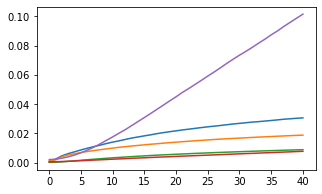

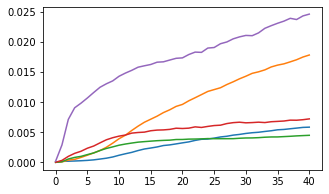

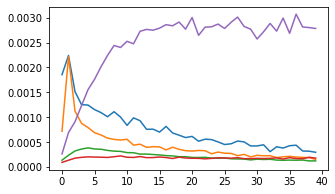

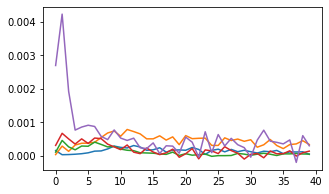

In [11]:
var_changes_L0_w, var_changes_L2_w, var_changes_L4_w, var_changes_L6_w, var_changes_L7_w = [], [], [], [], [] 
var_accumulate_L0_w, var_accumulate_L2_w, var_accumulate_L4_w, var_accumulate_L6_w, var_accumulate_L7_w = [], [], [], [], [] 

var_changes_L0_b, var_changes_L2_b, var_changes_L4_b, var_changes_L6_b, var_changes_L7_b = [], [], [], [], [] 
var_accumulate_L0_b, var_accumulate_L2_b, var_accumulate_L4_b, var_accumulate_L6_b, var_accumulate_L7_b = [], [], [], [], [] 


for global_epoch in range(G_epoch-1):
    for layer_index in num_layers_list:
        sumss_w, sumss_b = 0, 0
        for sks in range(num_cluster):
            sumss_w = sumss_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][0] 
            sumss_b = sumss_b + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][1]

        sumss_w = sumss_w/num_cluster
        sumss_b = sumss_b/num_cluster

        globals()['var_accumulate_L{}_w'.format(layer_index)].append(np.var( sumss_w ))
        
        globals()['var_accumulate_L{}_b'.format(layer_index)].append(np.var( sumss_b ))
        
        

for layer_index in num_layers_list:
    for tmp_int in range(len(globals()['var_accumulate_L{}_w'.format(layer_index)])-1):
        #print(tmp_int, tmp_int+1)
        minus_w = globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int]
        minus_b = globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int]        
        globals()['var_changes_L{}_w'.format(layer_index)].append( minus_w )
        globals()['var_changes_L{}_b'.format(layer_index)].append( minus_b )
        

print("Variance Accumulate Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Accumulate Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Accumulate Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_b'.format(j)])

print("\n\nVariance Change Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Changes Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_w'.format(j)])

print("\nVar Changes Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_b'.format(j)])



print("\nNow Check the graph\n")

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])


Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.03823224, 0.030201443, 0.014032956, 0.008464913, 0.007876581, 0.008316006, 0.009029827, 0.007975218, 0.008797907, 0.008395286, 0.008411439, 0.0069632, 0.0074694837, 0.0054356745, 0.004867927, 0.004683518, 0.005062912, 0.0039003124, 0.00398138, 0.0038953556, 0.0040061167, 0.0039672162, 0.003422857, 0.0035164505, 0.0036411907, 0.0034100134, 0.0032935133, 0.0031412852, 0.0030351034, 0.0032112459, 0.0027428356, 0.0025741318, 0.00264221, 0.0024649703, 0.0027617784, 0.0025686524, 0.0026851976, 0.002592292, 0.0024838727, 0.0023985505, 0.0024455958]
[0.04152655, 0.031753425, 0.020292107, 0.016621219, 0.012153115, 0.010461809, 0.0090919165, 0.009267435, 0.009367047, 0.009345536, 0.007998037, 0.008512364, 0.0077355066, 0.0068188664, 0.0067236824, 0.006074745, 0.0061168554, 0.0056655216, 0.005942961, 0.005389777, 0.005521101, 0.0053386507, 0.0050179446, 0.00538113, 0.0047

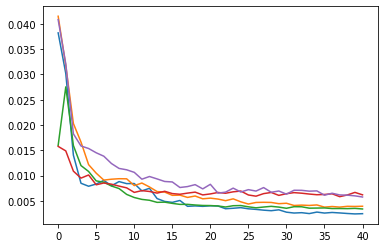

In [12]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch): #1이 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0    


for global_epoch in range(G_epoch):    #2가 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        var_w = 0
        for sks in range(globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]):
            var_w = var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)]

        var_w = var_w/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]

        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = var_w
        if global_epoch > 0:
            globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch-1, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch, layer_index)])))

print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.025901007, 0.05918691, 0.07931038, 0.08596693, 0.08837824, 0.08968919, 0.08918068, 0.088423766, 0.08815357, 0.08800203, 0.08992013, 0.09125231, 0.09395076, 0.09700901, 0.0997204, 0.10193719, 0.104581445, 0.10754642, 0.10951723, 0.111628, 0.11354709, 0.1157143, 0.11800059, 0.119959265, 0.12135437, 0.12299832, 0.12467776, 0.12606975, 0.12769273, 0.12913877, 0.13059974, 0.13193808, 0.13304754, 0.13422614, 0.13531052, 0.1365359, 0.13769811, 0.1388012, 0.13985206, 0.14081836, 0.14173587]
[0.030535659, 0.03729059, 0.062466815, 0.073909774, 0.08295524, 0.09056233, 0.09639332, 0.10167897, 0.1071399, 0.112350225, 0.11703438, 0.12071052, 0.124668375, 0.1277841, 0.1315237, 0.13376053, 0.13656865, 0.13908999, 0.14133045, 0.14382608, 0.14589936, 0.14858478, 0.15035313, 0.15285394, 0.15463871, 0.15650357, 0.15814845, 0.15987752, 0.1620875, 0.16402782, 0.16531755, 0.16708301,

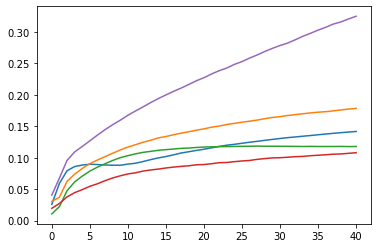

In [13]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch): #1이 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0    


for global_epoch in range(G_epoch-1):    #2가 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        var_w = 0
        for sks in range(globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]):
            var_w = var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)]

        var_w = var_w/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]

        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = var_w
        #print(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)])
        globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)])))

print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

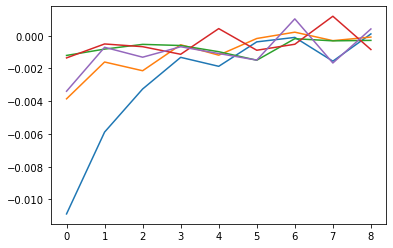

In [14]:
import matplotlib.pyplot as plt

s0 = [0.033442218, 0.022558995, 0.016673164, 0.013417845, 0.0120947845, 0.010224614, 0.009847336, 0.009742555, 0.008186322, 0.008294276]
s1 = [0.020990413, 0.017134858, 0.01552761, 0.013387308, 0.012832965, 0.0116436295, 0.011472162, 0.011686606, 0.01138394, 0.011299784]
s2 = [0.015713232, 0.014507645, 0.013688376, 0.013158151, 0.012558694, 0.011580729, 0.010083127, 0.009900561, 0.009584863, 0.009298261]
s3 = [0.013935264, 0.012578766, 0.012073863, 0.011402234, 0.010267887, 0.010700155, 0.009811351, 0.009288852, 0.010476284, 0.009631331]
s4 = [0.022094166, 0.018702243, 0.017993856, 0.016680326, 0.016005656, 0.014916321, 0.013425422, 0.014452046, 0.012784476, 0.013196317] 

s0_diff, s1_diff, s2_diff, s3_diff, s4_diff = [], [], [], [], []

for i in range(len(s0)-1):
    s0_diff.append(s0[i+1] - s0[i])
    s1_diff.append(s1[i+1] - s1[i])
    s2_diff.append(s2[i+1] - s2[i])
    s3_diff.append(s3[i+1] - s3[i])
    s4_diff.append(s4[i+1] - s4[i])


plt.plot(s0_diff)
plt.plot(s1_diff)
plt.plot(s2_diff)
plt.plot(s3_diff)
plt.plot(s4_diff)

[[0.8180000185966492, 0.800000011920929, 0.8059999942779541, 0.7860000133514404, 0.8019999861717224, 0.7720000147819519, 0.777999997138977, 0.765999972820282, 0.8159999847412109, 0.7940000295639038, 0.7739999890327454, 0.8119999766349792, 0.8100000023841858, 0.7919999957084656, 0.7799999713897705, 0.8019999861717224, 0.7680000066757202, 0.7979999780654907, 0.8100000023841858, 0.8320000171661377], [0.7160000205039978, 0.6700000166893005, 0.6380000114440918, 0.7480000257492065, 0.6919999718666077, 0.765999972820282, 0.75, 0.6959999799728394, 0.7099999785423279, 0.7099999785423279, 0.6919999718666077, 0.6980000138282776, 0.722000002861023, 0.7680000066757202, 0.6819999814033508, 0.6200000047683716, 0.7080000042915344, 0.6819999814033508, 0.7020000219345093, 0.6919999718666077], [0.7059999704360962, 0.7540000081062317, 0.7480000257492065, 0.734000027179718, 0.7200000286102295, 0.722000002861023, 0.7580000162124634, 0.7440000176429749, 0.7559999823570251, 0.7300000190734863, 0.7459999918937

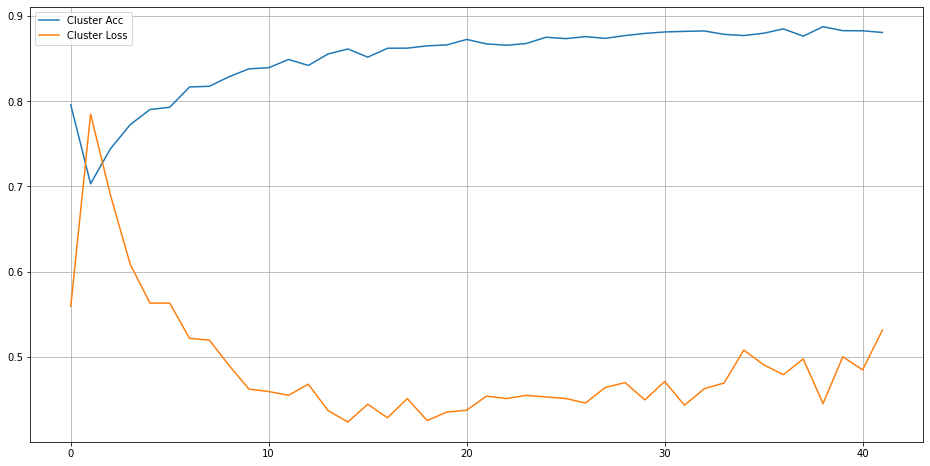

In [15]:
average_acc_cluster_list, average_loss_cluster_list = [], []


for i in range(len(Cluster_ACC)):    
    average_acc_cluster_list.append(np.mean(Cluster_ACC[i]))
    average_loss_cluster_list.append(np.mean(Cluster_LOSS[i]))

    
plt.figure(figsize=(16,8))
plt.plot(average_acc_cluster_list, label='Cluster Acc')
print(Cluster_ACC)
print(Cluster_LOSS,"\n\n\n")
plt.plot(average_loss_cluster_list, label='Cluster Loss')

plt.grid(True)
plt.legend()
plt.show()


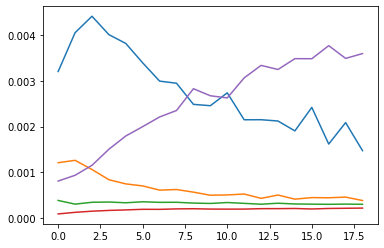

In [16]:
a0 = [0.003205364, 0.004054614, 0.0044148304, 0.0040123863, 0.0038194992, 0.0033943746, 0.002995275, 0.0029489305, 0.0024865456, 0.0024573095, 0.0027383938, 0.00214969, 0.0021506958, 0.0021224543, 0.0019059442, 0.0024203248, 0.0016179904, 0.002087362, 0.0014732778]
a1 = [0.0012099252, 0.0012620839, 0.0010611771, 0.0008376553, 0.0007461193, 0.0007019113, 0.0006098342, 0.0006231889, 0.0005656723, 0.0004983349, 0.0005047526, 0.00052430946, 0.00043012202, 0.0005026031, 0.00041222572, 0.0004462581, 0.0004424844, 0.00045725983, 0.0003821971]
a2 = [0.0003839716, 0.000303254, 0.0003441152, 0.00034959195, 0.0003332547, 0.00035521504, 0.0003424387, 0.0003441011, 0.0003261196, 0.00031830696, 0.0003387872, 0.00032045273, 0.00030170754, 0.00032332726, 0.00030716136, 0.0003025909, 0.00029967912, 0.00030403072, 0.00030000368]
a3 = [8.9404755e-05, 0.00012393983, 0.00014912727, 0.00016565016, 0.00017713726, 0.00019022368, 0.00018933346, 0.00019920385, 0.00020293845, 0.0001952136, 0.00019410136, 0.00019478262, 0.00020432798, 0.00020491402, 0.00020831544, 0.00019722758, 0.00020881696, 0.00021286262, 0.00021679513]
a4 = [0.00080826925, 0.0009351289, 0.001152637, 0.0015045712, 0.0017947452, 0.0019997023, 0.0022111395, 0.0023525897, 0.002828911, 0.0026749372, 0.0026274268, 0.003066074, 0.0033393148, 0.003249837, 0.0034868643, 0.0034852102, 0.0037708618, 0.0034923442, 0.0035977662]

plt.plot(a0)
plt.plot(a1)
plt.plot(a2)
plt.plot(a3)
plt.plot(a4)